# Object detection


In [61]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.1.0
The following GPU devices are available: /device:GPU:0


## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [62]:
def display_image(image):
    #   fig = plt.figure(figsize=(20, 15))
    fig = plt.figure(figsize=(3, 3))
    plt.grid(False)
    plt.imshow(image)


    def download_and_resize_image(url, new_width=256, new_height=256,
                                  display=False):
        _, filename = tempfile.mkstemp(suffix=".jpg")
        response = urlopen(url)
        image_data = response.read()
        image_data = BytesIO(image_data)
        pil_image = Image.open(image_data)
        pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
        pil_image_rgb = pil_image.convert("RGB")
        pil_image_rgb.save(filename, format="JPEG", quality=90)
        print("Image downloaded to %s." % filename)
        if display:
            display_image(pil_image)
            return filename


        def draw_bounding_box_on_image(image,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       thickness=4,
                                       display_str_list=()):
            """Adds a bounding box to an image."""
            draw = ImageDraw.Draw(image)
            im_width, im_height = image.size
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                       (left, top)],
                      width=thickness,
                      fill=color)

            # If the total height of the display strings added to the top of the bounding
            # box exceeds the top of the image, stack the strings below the bounding box
            # instead of above.
            display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
            # Each display_str has a top and bottom margin of 0.05x.
            total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

            if top > total_display_str_height:
                text_bottom = top
            else:
                text_bottom = top + total_display_str_height
                # Reverse list and print from bottom to top.
                for display_str in display_str_list[::-1]:
                    text_width, text_height = font.getsize(display_str)
                    margin = np.ceil(0.05 * text_height)
                    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                                    (left + text_width, text_bottom)],
                                   fill=color)
                    draw.text((left + margin, text_bottom - text_height - margin),
                              display_str,
                              fill="black",
                              font=font)
                    text_bottom -= text_height - 2 * margin


                    def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
                        """Overlay labeled boxes on an image with formatted scores and label names."""
                        colors = list(ImageColor.colormap.values())

                        try:
                            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                                      25)
                            except IOError:
                                print("Font not found, using default font.")
                                font = ImageFont.load_default()

                                for i in range(min(boxes.shape[0], max_boxes)):
                                    if scores[i] >= min_score:
                                        ymin, xmin, ymax, xmax = tuple(boxes[i])
                                        display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                                                       int(100 * scores[i]))
                                        color = colors[hash(class_names[i]) % len(colors)]
                                        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
                                        draw_bounding_box_on_image(
                                            image_pil,
                                            ymin,
                                            xmin,
                                            ymax,
                                            xmax,
                                            color,
                                            font,
                                            display_str_list=[display_str])
                                        np.copyto(image, np.array(image_pil))
                                        return image

SyntaxError: invalid syntax (<ipython-input-62-0811d818954c>, line 52)

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to C:\Apps\cygwin\tmp\tmptla9vp_j.jpg.


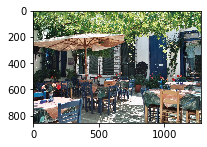

In [63]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [64]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [65]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [66]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

Found 100 objects.
Inference time:  44.03440475463867
Font not found, using default font.


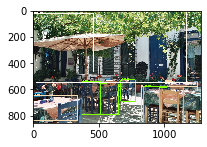

In [67]:
run_detector(detector, downloaded_image_path)

### More images
Perform inference on some additional images with time tracking.


In [68]:
image_urls = [
    # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
    "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
    # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
    # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
    "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",start_time-end_time)

In [69]:
def run_detector1(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time (Detection): ", end_time-start_time)

    print(result["detection_class_entities"], result["detection_scores"])
    
    for idx in range(len(result["detection_class_entities"])):
        if result["detection_class_entities"][idx] == b'Building':
            print(idx, result["detection_class_entities"][idx], result["detection_scores"][idx])

Found 100 objects.
Inference time (Detection):  0.702404260635376
[b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Tree'
 b'Building' b'Tree' b'Building' b'Tree' b'Building' b'Tree' b'Tree'
 b'Tree' b'Tree' b'Tree' b'Building' b'Tree' b'Tree' b'Tree' b'Tree'
 b'Tree' b'Tree' b'House' b'Tree' b'Tree' b'Tree' b'Window' b'Tree'
 b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Tree' b'Plant'
 b'Building' b'Tree' b'Plant' b'Tree' b'Tree' b'Tree' b'Plant' b'Plant'
 b'Tree' b'Tree' b'Tree' b'Tree' b'Flowerpot' b'Tree' b'Plant' b'Tree'
 b'Tree' b'Tree' b'Tree' b'Plant' b'House' b'House' b'Tree' b'House'
 b'Picture frame' b'Tree' b'Plant' b'Plant' b'Tree' b'Houseplant'
 b'Poster' b'Castle' b'Vehicle' b'Building' b'Palm tree' b'Tree' b'Tree'
 b'Building' b'Building' b'Tree' b'Building' b'House' b'Building' b'Tree'
 b'Tree' b'Building' b'Tree' b'House' b'Building' b'Tree' b'Plant'
 b'Land vehicle' b'Tree' b'Plant' b'Car' b'Building' b'Plant' b'Tree'
 b'House' b'Window' b'Tower'] [0.82

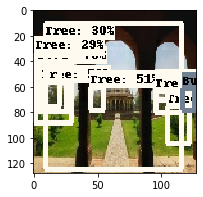

In [70]:
image_path1 = "datasets\\group1_set_128\\set_128\\train\\27\\3a8e9ffccae326f1.jpg"
run_detector1(detector, image_path1)
run_detector(detector, image_path1)

In [71]:
def detect_img1(image_url):
    image_path = download_and_resize_image(image_url, 128, 128)
    print(image_path)
    run_detector1(detector, image_path)

In [72]:
custom_image_url = "https://www.thoughtco.com/thmb/DBOgHVGLrn4Hy6OOlJxcdExAYuE=/768x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/sunrise-at-taj-mahal--agra--uttar-pradash--india-583682538-5b91840bc9e77c0050bdc67b.jpg"
detect_img1(custom_image_url)

Image downloaded to C:\Apps\cygwin\tmp\tmpehv0atep.jpg.
C:\Apps\cygwin\tmp\tmpehv0atep.jpg
Found 100 objects.
Inference time (Detection):  0.8518633842468262
[b'Building' b'Building' b'Tree' b'Rocket' b'Tree' b'Tree' b'Rocket'
 b'Missile' b'Tower' b'Street light' b'Missile' b'Tree' b'Castle' b'Plant'
 b'Tree' b'Tree' b'Tree' b'Tower' b'Street light' b'Tree' b'Street light'
 b'Tower' b'Tower' b'Window' b'Building' b'Building' b'Building' b'Tower'
 b'Building' b'Tree' b'Building' b'Person' b'Missile' b'Rocket' b'Tree'
 b'Tower' b'Lighthouse' b'Tree' b'Tree' b'Castle' b'Window' b'Tower'
 b'Tree' b'Building' b'Missile' b'Tree' b'House' b'Tree' b'Clothing'
 b'House' b'Person' b'Person' b'Tower' b'Tree' b'Tree' b'Mammal' b'Tree'
 b'Street light' b'Toy' b'Building' b'Building' b'Sculpture'
 b'Street light' b'Mammal' b'Plant' b'Tree' b'Building' b'Tree' b'Plant'
 b'Plant' b'Plant' b'Building' b'Vehicle' b'Window' b'Person' b'Tree'
 b'Plant' b'House' b'Tree' b'Poster' b'Building' b'Tree' b'Towe

Image downloaded to C:\Apps\cygwin\tmp\tmpx1eab4z_.jpg.
Found 100 objects.
Inference time:  5.621310472488403
Font not found, using default font.
Inference time: -5.864283561706543


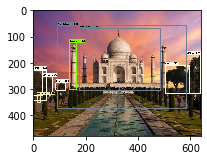

In [73]:
custom_image_url = "https://www.thoughtco.com/thmb/DBOgHVGLrn4Hy6OOlJxcdExAYuE=/768x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/sunrise-at-taj-mahal--agra--uttar-pradash--india-583682538-5b91840bc9e77c0050bdc67b.jpg"
detect_img(custom_image_url)

Image downloaded to C:\Apps\cygwin\tmp\tmp_2kd5_ec.jpg.
Found 100 objects.
Inference time:  0.08358907699584961
Font not found, using default font.
Inference time: -0.4260103702545166


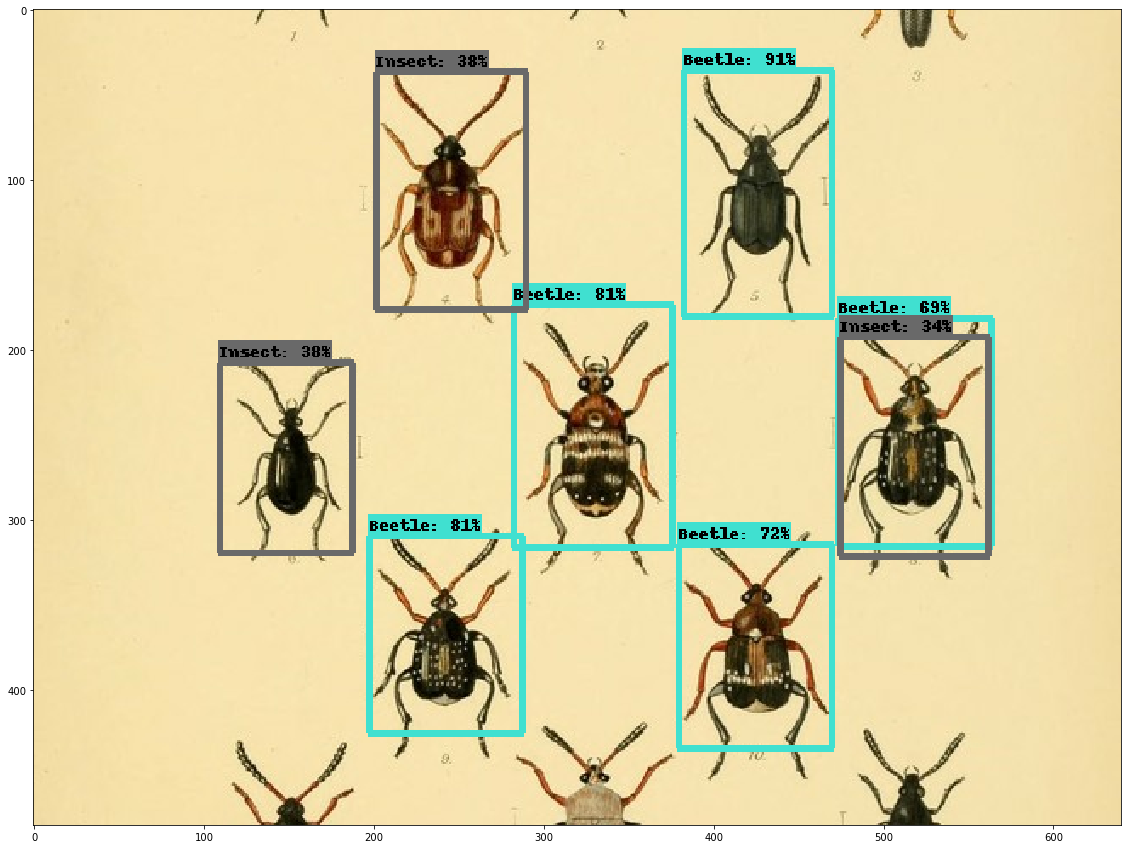

In [14]:
detect_img(image_urls[0])

Image downloaded to C:\Apps\cygwin\tmp\tmpx27t38hv.jpg.
Found 100 objects.
Inference time:  0.09572172164916992
Font not found, using default font.
Inference time: -0.41282176971435547


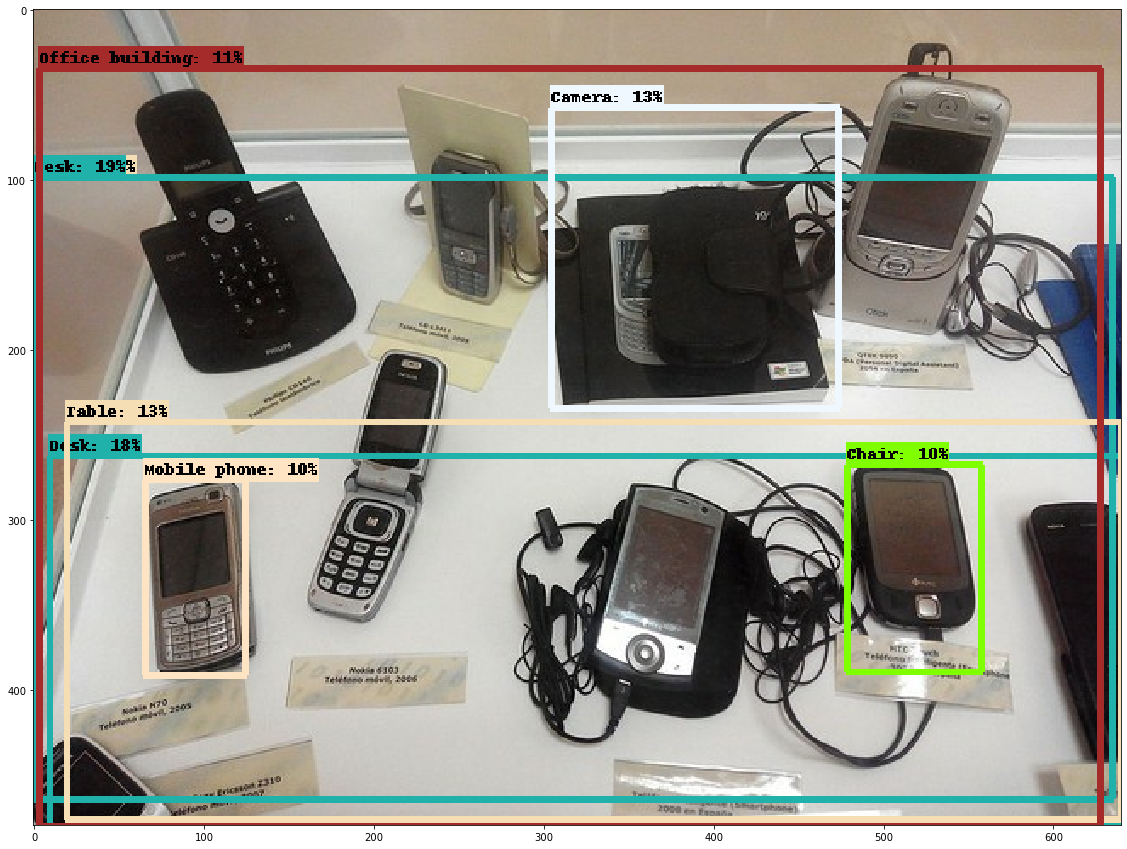

In [15]:
detect_img(image_urls[1])

Image downloaded to C:\Apps\cygwin\tmp\tmpvqkass93.jpg.
Found 100 objects.
Inference time:  0.11061215400695801
Font not found, using default font.
Inference time: -0.6472601890563965


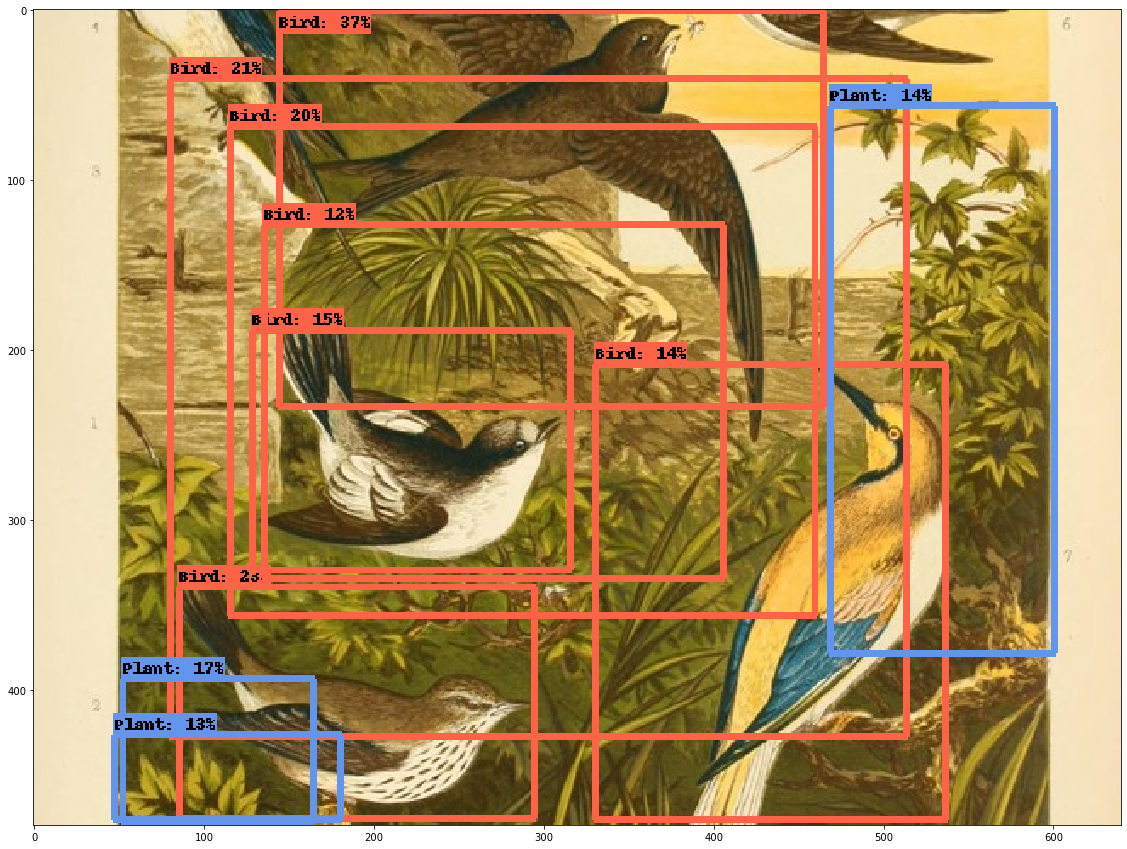

In [16]:
detect_img(image_urls[2])